In [31]:
#import all necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load and split the data set
data_dir = 'flower_photos/flower_photos'
train_ds = image_dataset_from_directory(data_dir, validation_split = 0.1, subset = "training", seed = 42, batch_size = None)
test_ds = image_dataset_from_directory(data_dir, validation_split = 0.1, subset = "validation", seed = 42, batch_size = None)

Found 3670 files belonging to 5 classes.
Using 3303 files for training.
Found 3670 files belonging to 5 classes.
Using 367 files for validation.


In [3]:
#extract the image/class label pair
x_train = []
y_train = []
for x, y in train_ds:
    x_train.append(np.uint8(x.numpy()))
    y_train.append(y.numpy())

In [4]:
x_test = []
y_test = []
for x, y in test_ds:
    x_test.append(np.uint8(x.numpy()))
    y_test.append(y.numpy())

In [5]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [6]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [7]:
print("x_train shape is:", x_train.shape)
print("x_test shape is:", x_test.shape)
print("y_train shape is:", y_train.shape)
print("y_test shape is:", y_test.shape)

x_train shape is: (3303, 256, 256, 3)
x_test shape is: (367, 256, 256, 3)
y_train shape is: (3303,)
y_test shape is: (367,)


In [8]:
print(train_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


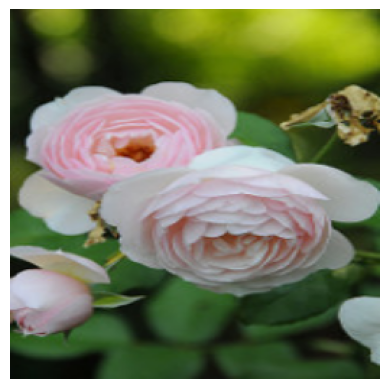

In [9]:
plt.imshow(x_train[0])
plt.gca().axis("off")
plt.show()

In [10]:
class_names = np.unique(y_train)
print(class_names)

[0 1 2 3 4]


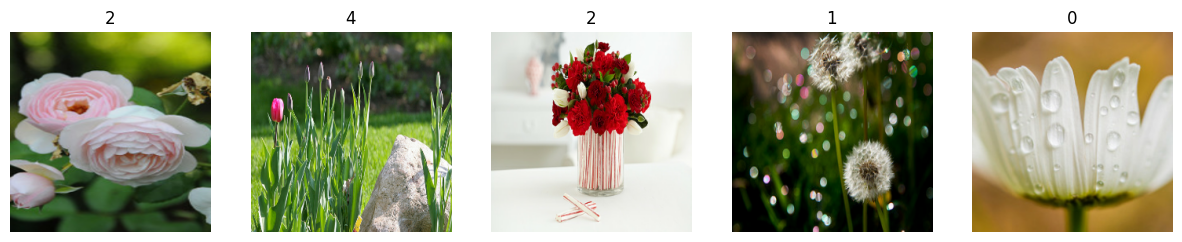

In [11]:
fig, axs = plt.subplots(1, 5, figsize = (15, 3))
for i in range(5):
    axs[i].imshow(x_train[i])
    axs[i].set_title(class_names[y_train[i]])
    axs[i].axis("off")
plt.show()

In [12]:
print(y_train[:5])

[2 4 2 1 0]


In [13]:
# convert the output data to use One Hot Encoding
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)
print('Original labels :', y_train[:5])
print('One hot encoded labels :', y_train_cat[:5])

Original labels : [2 4 2 1 0]
One hot encoded labels : [[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [14]:
print(f'Minimum pixel = {min(x_train[0].flatten())}')
print(f'Maximum pixel = {max(x_train[0].flatten())}')
print(f'Data type = {x_train.dtype}')

Minimum pixel = 0
Maximum pixel = 237
Data type = uint8


In [15]:
# Normalise the images by dividing by 255
x_train_norm = x_train.astype('float32') / 255.
x_test_norm = x_test.astype('float32') / 255

In [16]:
x_train.shape

(3303, 256, 256, 3)

Text(0.5, 0, 'Argumented image')

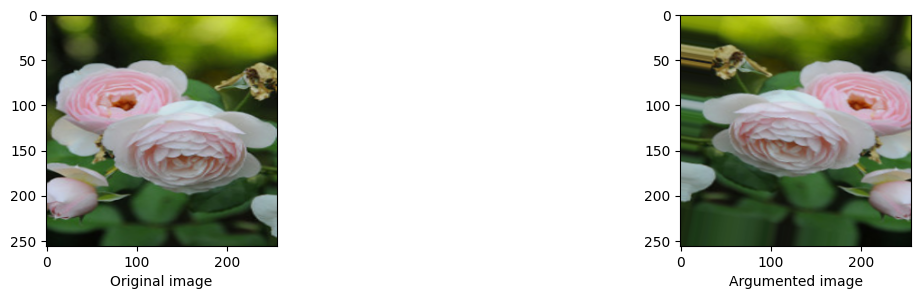

In [17]:
# apply random transformations to the images
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.10,
    zoom_range = 0.10,
    validation_split =0.2
)
train_datagen.fit(x_train)
new_image = train_datagen.random_transform(x_train[0])

fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].imshow(x_train[0])
axs[1].imshow(new_image)
axs[0].set_xlabel('Original image')
axs[1].set_xlabel('Argumented image')

In [18]:
width_npix = x_train.shape[1]
height_npix = x_train.shape[2]
print(width_npix)
print(height_npix)

256
256


### Build the CNN model

In [33]:
def cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs):
    '''developes and compiles a CNN model using different batch_size, kernel size, pooling layers,
    learning rate, strides, padding, Batch normalization
    '''

    def add_pooling_layer():
        '''adds a pooling layer to a model'''
        
        if pooling == 'max':
            return MaxPooling2D(pool_size = (2, 2), padding = padding)
        else:
            return AveragePooling2D(pool_size = (2, 2), padding = padding)

    # Create an instance of the Sequential class (our model)
    model = Sequential()
    
    # Add the first Convolutional block
    model.add(Conv2D(filters = 32, kernel_size = kernel, strides = strides, padding = padding, input_shape = (width_npix, height_npix, 3), activation = 'relu'))
    model.add(add_pooling_layer())
    if momentum:
        model.add(BatchNormalization(momentum = momentum))
    
    # Add the second Convolutional block
    model.add(Conv2D(filters = 64, kernel_size = kernel, strides = strides, padding = padding, activation = 'relu'))
    model.add(add_pooling_layer())
    if momentum:
        model.add(BatchNormalization(momentum = momentum))

    # Add the third Convolutional block
    model.add(Conv2D(filters = 128, kernel_size = kernel, strides = strides, padding = padding, activation = 'relu'))
    model.add(add_pooling_layer())
    if momentum:
        model.add(BatchNormalization(momentum = momentum))

    # add a flatter layer
    model.add(Flatten())
    # add a dense layer
    model.add(Dense(64, activation = 'relu'))
    # add a drop out of 50%
    model.add(Dropout(0.5))
    # add an output layer
    model.add(Dense(5, activation = 'softmax'))
    # print the sumarry
    model.summary()
    # set the learning rate
    adam_optimizer = Adam(learning_rate = learning_rate)
    # compile the model
    model.compile(adam_optimizer, loss='categorical_crossentropy', metrics='accuracy')
    # set the batch size
    batch_size = batch_size
    # fit the model
    history = model.fit(train_datagen.flow(x_train_norm, y_train_cat, batch_size = batch_size, subset = "training"), epochs = epochs,
    validation_data = train_datagen.flow(x_train_norm, y_train_cat, batch_size = batch_size, subset = "validation"))
    return [model, history]

In [20]:
def loss_accuracy_graph(history):
    '''Plots the loss and accuracy graphs'''
    
    history_df = pd.DataFrame(history.history)

    plt.plot(history_df["loss"], label = "Training")
    plt.plot(history_df["val_loss"], label = "Validation")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss = Cross Entropy")

    plt.show()

    plt.plot(history_df["accuracy"], label = "Training")
    plt.plot(history_df["val_accuracy"], label = "Validation")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()

In [21]:
def confusion_matrix_metrics(model):
    '''Plots tyhe confusion matrix'''
    
    y_pred = model.predict(x_test_norm)

    y_pred_class = np.argmax(y_pred, axis=1)
    con_mat = confusion_matrix(y_test, y_pred_class, labels = numerical_labels)

    ax = plt.axes()
    disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels =display_labels)
    disp.plot(ax = ax)
    plt.show()
    
    # Print the classification report, using the predicted class labels for the testing set obtained from the model.
    print(classification_report(y_test, y_pred_class))

### Compile the CNN model

In [22]:
# **** MODEL 1 ****

batch_size = 32
kernel = (3, 3)
pooling = 'max'
learning_rate = 0.01
strides = (1, 1)
padding = 'valid'
momentum = 0
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

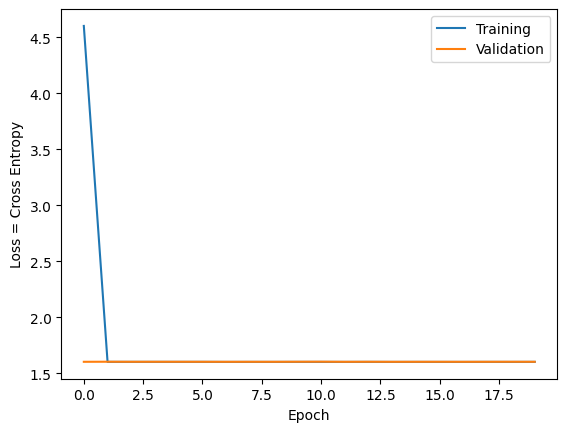

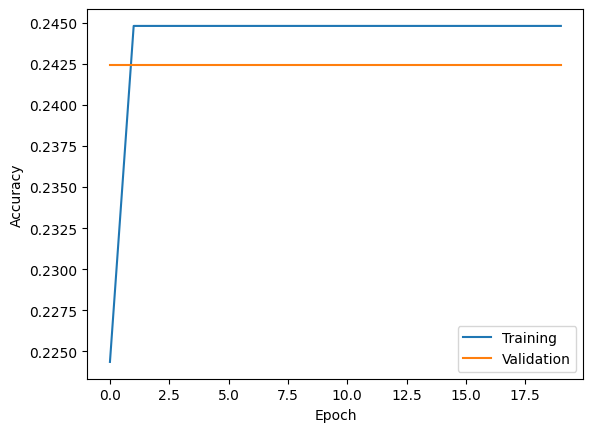

12/12 [==============================] - 4s 311ms/step


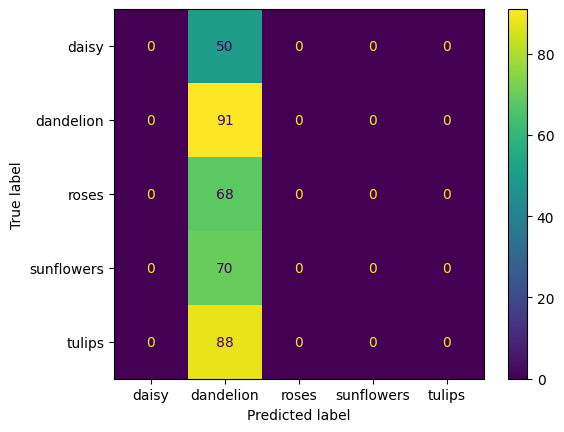

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.25      1.00      0.40        91
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        88

    accuracy                           0.25       367
   macro avg       0.05      0.20      0.08       367
weighted avg       0.06      0.25      0.10       367



In [23]:
display_labels = [i for i in train_ds.class_names]
numerical_labels = [i for i in range(5)]

loss_accuracy_graph(history)
confusion_matrix_metrics(model)

#### Hyper parameter tunning

In [24]:
# **** MODEL 2 ****

# Increase the batch size to 128
batch_size = 128
kernel = (3, 3)
pooling = 'max'
learning_rate = 0.01
strides = (1, 1)
padding = 'valid'
momentum = 0
epochs = 20

model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

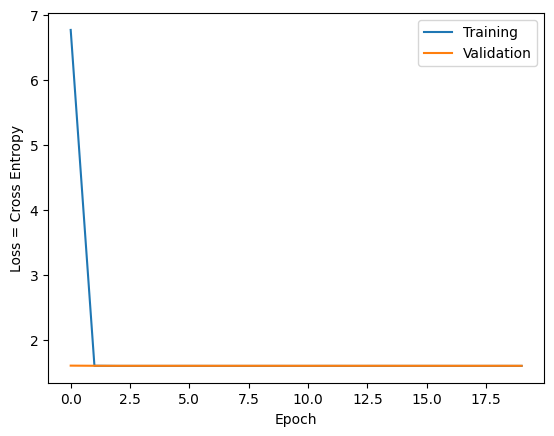

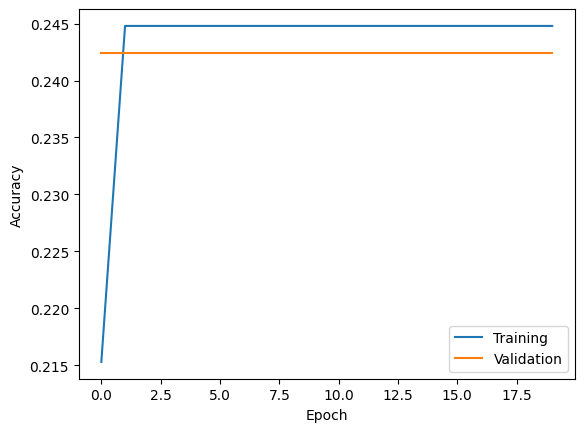

12/12 [==============================] - 4s 313ms/step


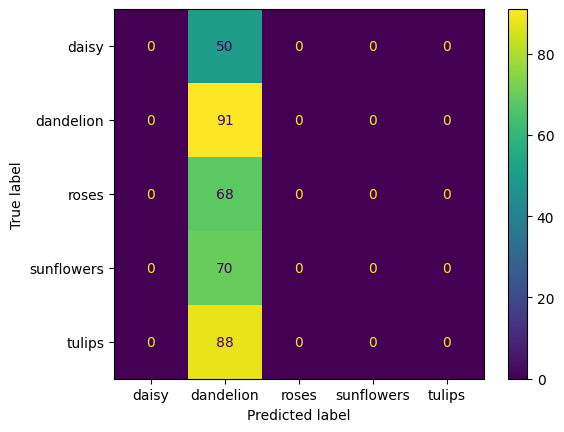

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.25      1.00      0.40        91
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        88

    accuracy                           0.25       367
   macro avg       0.05      0.20      0.08       367
weighted avg       0.06      0.25      0.10       367



In [25]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [26]:
# **** MODEL 3 ****

# Increase the srides to 2
batch_size = 128
kernel = (3, 3)
pooling = 'max'
learning_rate = 0.01
strides = (2, 2)
padding = 'same'
momentum = 0
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

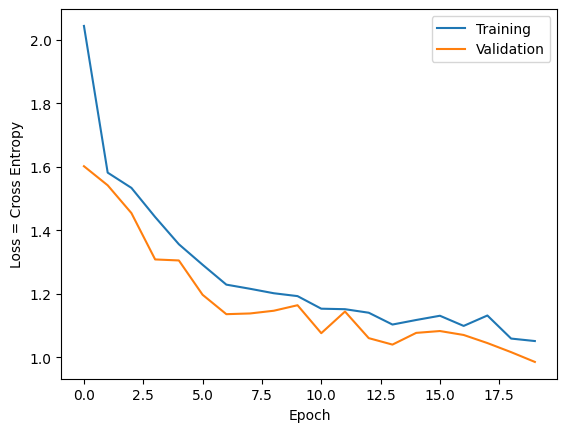

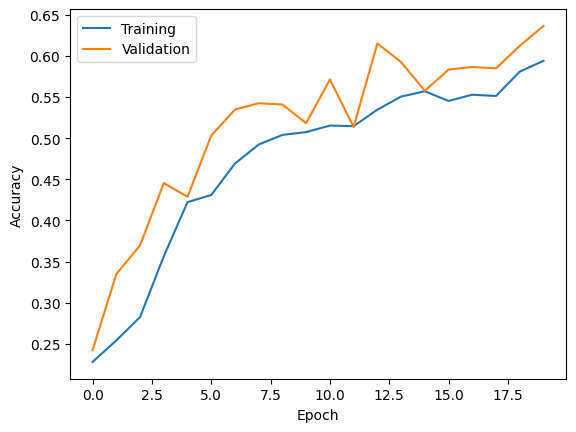

12/12 [==============================] - 1s 52ms/step


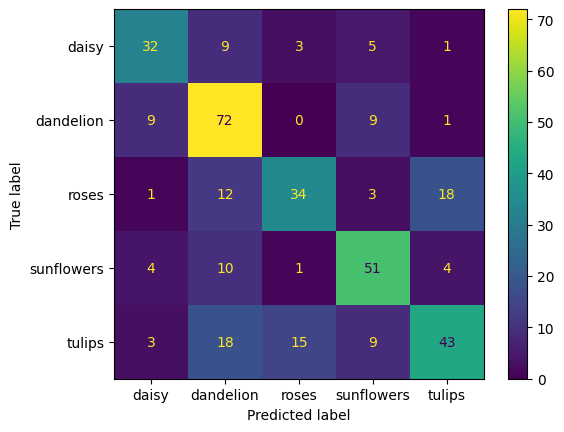

              precision    recall  f1-score   support

           0       0.65      0.64      0.65        50
           1       0.60      0.79      0.68        91
           2       0.64      0.50      0.56        68
           3       0.66      0.73      0.69        70
           4       0.64      0.49      0.55        88

    accuracy                           0.63       367
   macro avg       0.64      0.63      0.63       367
weighted avg       0.64      0.63      0.63       367



In [27]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [28]:
# **** MODEL 4 ****

# Increase the kernel size and set padding to 'same'
batch_size = 128
kernel = (5, 5)
pooling = 'max'
learning_rate = 0.01
strides = (2, 2)
padding = 'same'
momentum = 0
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)       

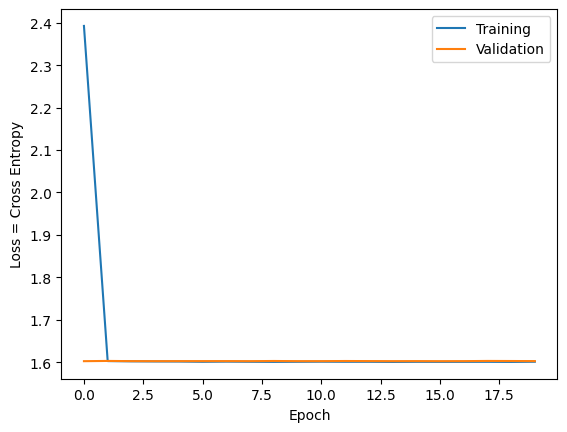

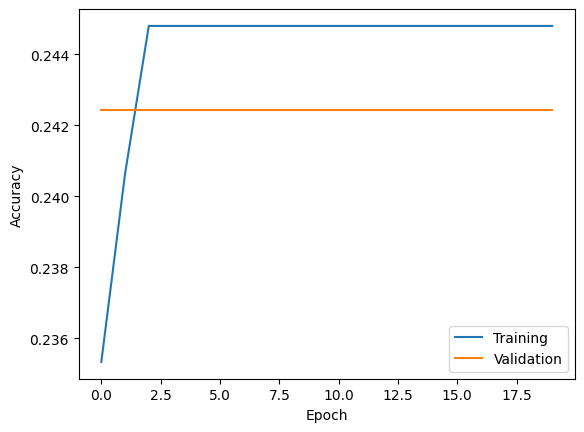

12/12 [==============================] - 1s 70ms/step


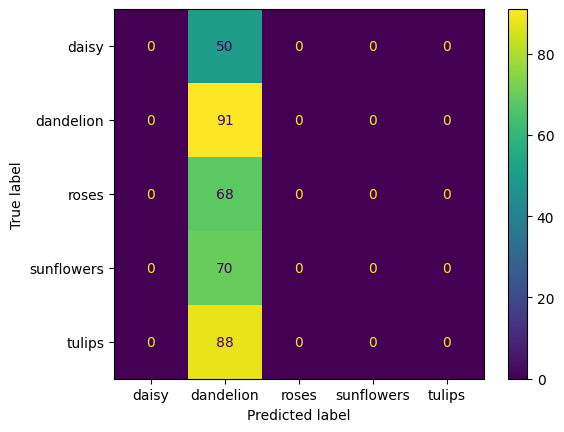

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.25      1.00      0.40        91
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        88

    accuracy                           0.25       367
   macro avg       0.05      0.20      0.08       367
weighted avg       0.06      0.25      0.10       367



In [29]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [34]:
# **** MODEL 5 ****

# Use an Average pooling layer
batch_size = 128
kernel = (3, 3)
pooling = 'average'
learning_rate = 0.01
strides = (2, 2)
padding = 'same'
momentum = 0
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 4, 4, 128)       

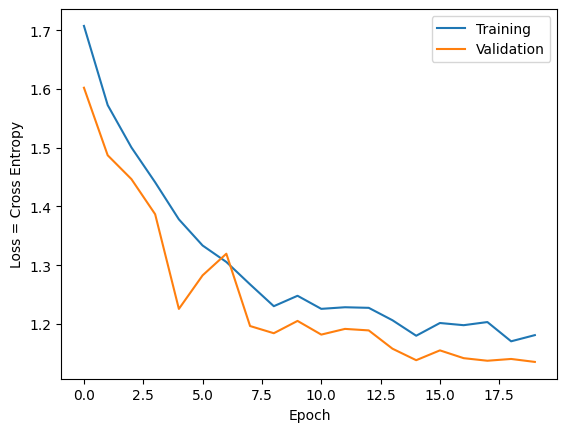

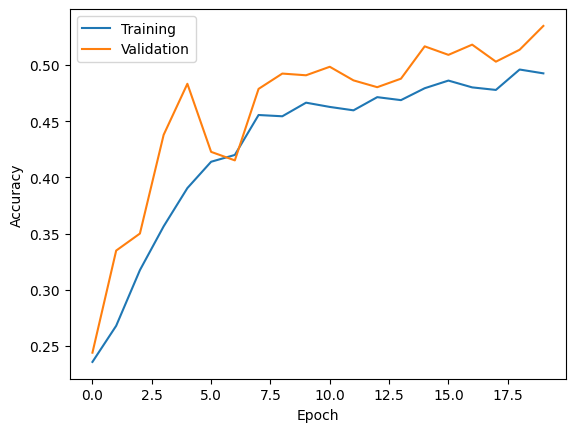

12/12 [==============================] - 1s 56ms/step


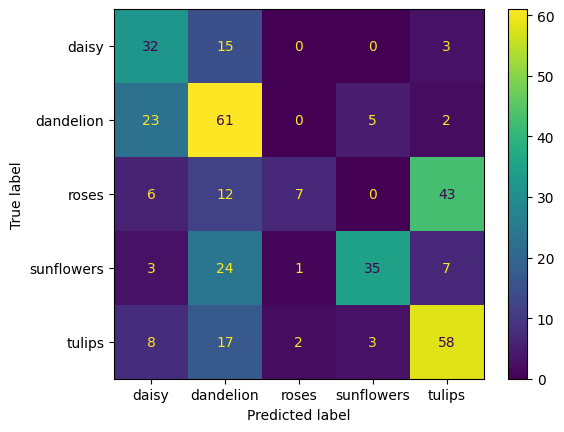

              precision    recall  f1-score   support

           0       0.44      0.64      0.52        50
           1       0.47      0.67      0.55        91
           2       0.70      0.10      0.18        68
           3       0.81      0.50      0.62        70
           4       0.51      0.66      0.58        88

    accuracy                           0.53       367
   macro avg       0.59      0.51      0.49       367
weighted avg       0.59      0.53      0.50       367



In [35]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [36]:
# **** MODEL 6 ****

# Add Batch Normalization to the Pooling layer
batch_size = 128
kernel = (3, 3)
pooling = 'average'
learning_rate = 0.01
strides = (2, 2)
padding = 'same'
momentum = 0.9
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 average_pooling2d_3 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                      

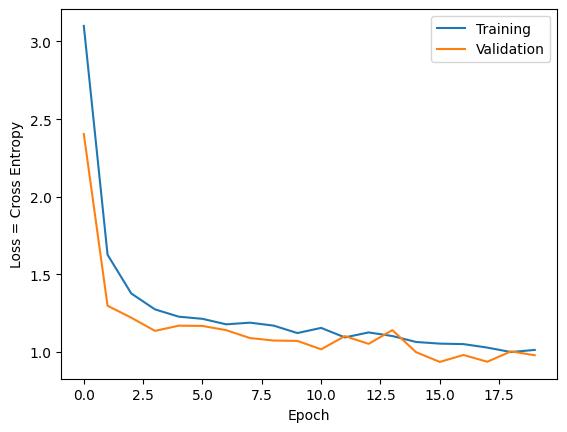

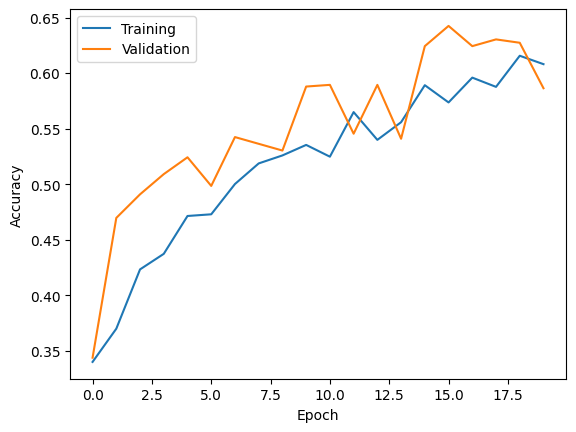

12/12 [==============================] - 1s 63ms/step


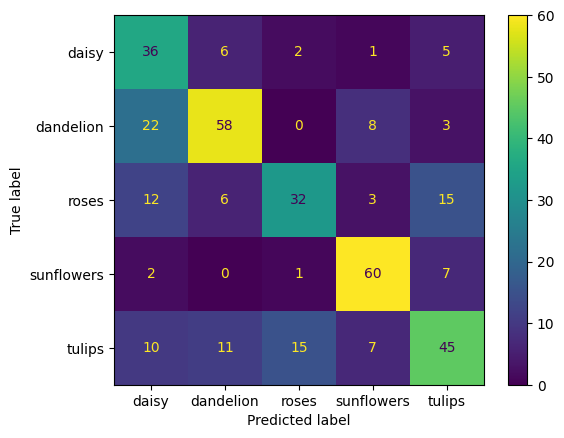

              precision    recall  f1-score   support

           0       0.44      0.72      0.55        50
           1       0.72      0.64      0.67        91
           2       0.64      0.47      0.54        68
           3       0.76      0.86      0.81        70
           4       0.60      0.51      0.55        88

    accuracy                           0.63       367
   macro avg       0.63      0.64      0.62       367
weighted avg       0.64      0.63      0.63       367



In [37]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [38]:
# **** MODEL 7 ****

# reduce the learning rate to 0.001
batch_size = 128
kernel = (3, 3)
pooling = 'average'
learning_rate = 0.001
strides = (2, 2)
padding = 'same'
momentum = 0.9
epochs = 20
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 average_pooling2d_6 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_7 (Averag  (None, 16, 16, 64)       0         
 ePooling2D)                                                     
                                                      

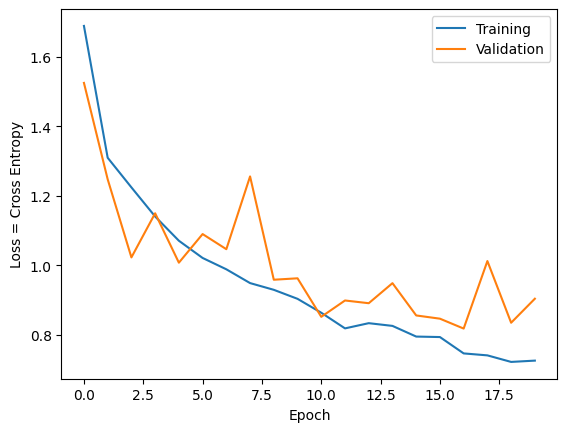

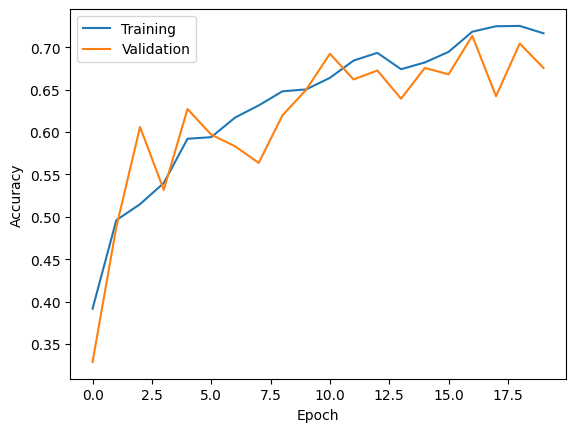

12/12 [==============================] - 1s 63ms/step


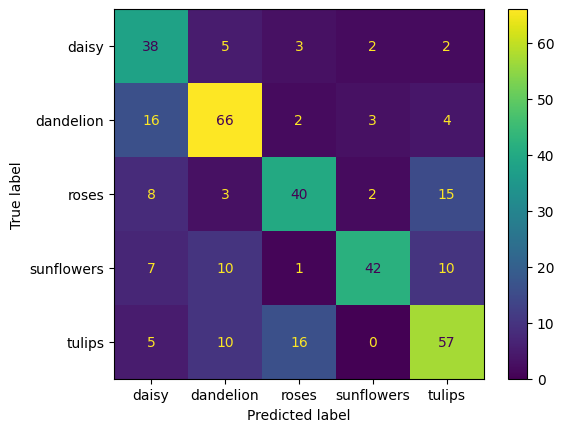

              precision    recall  f1-score   support

           0       0.51      0.76      0.61        50
           1       0.70      0.73      0.71        91
           2       0.65      0.59      0.62        68
           3       0.86      0.60      0.71        70
           4       0.65      0.65      0.65        88

    accuracy                           0.66       367
   macro avg       0.67      0.66      0.66       367
weighted avg       0.68      0.66      0.66       367



In [39]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [40]:
# **** MODEL 8 ****
# Increase the training time of MODEL 3 to 35 epochs

batch_size = 128
kernel = (3, 3)
pooling = 'max'
learning_rate = 0.01
strides = (2, 2)
padding = 'same'
momentum = 0
epochs = 35
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 128)       

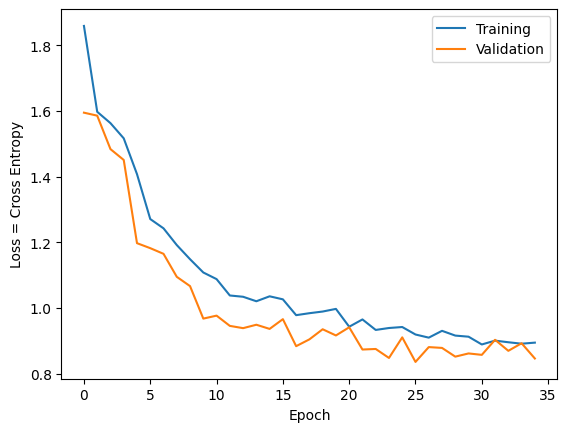

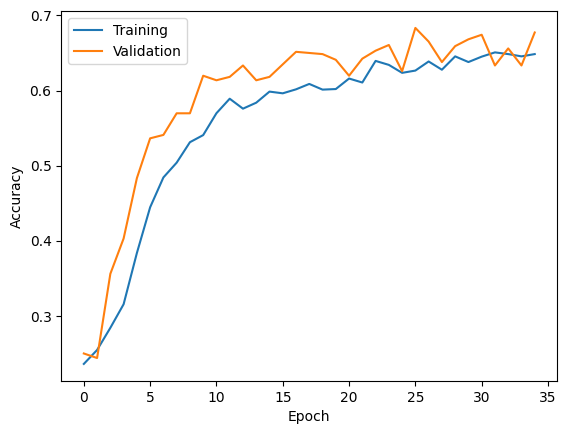

12/12 [==============================] - 1s 66ms/step


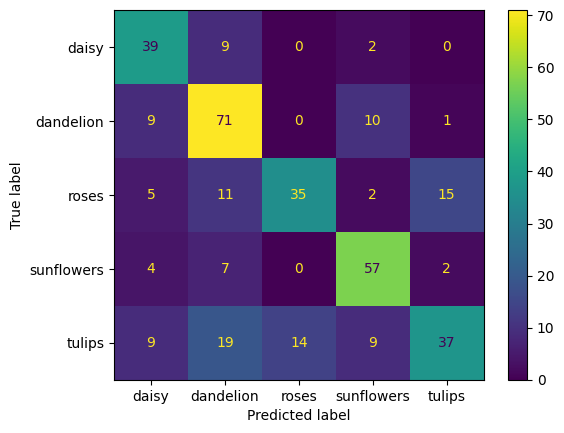

              precision    recall  f1-score   support

           0       0.59      0.78      0.67        50
           1       0.61      0.78      0.68        91
           2       0.71      0.51      0.60        68
           3       0.71      0.81      0.76        70
           4       0.67      0.42      0.52        88

    accuracy                           0.65       367
   macro avg       0.66      0.66      0.65       367
weighted avg       0.66      0.65      0.64       367



In [41]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)

In [44]:
# **** MODEL 9 ****

#Increase the learning period of MODEL 7 to 35 epochs
batch_size = 128
kernel = (3, 3)
pooling = 'average'
learning_rate = 0.001
strides = (2, 2)
padding = 'same'
momentum = 0.9
epochs = 35
model, history = cnn_model(batch_size, kernel, pooling, learning_rate, strides, padding, momentum, epochs)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 average_pooling2d_12 (Avera  (None, 64, 64, 32)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 average_pooling2d_13 (Avera  (None, 16, 16, 64)       0         
 gePooling2D)                                                    
                                                     

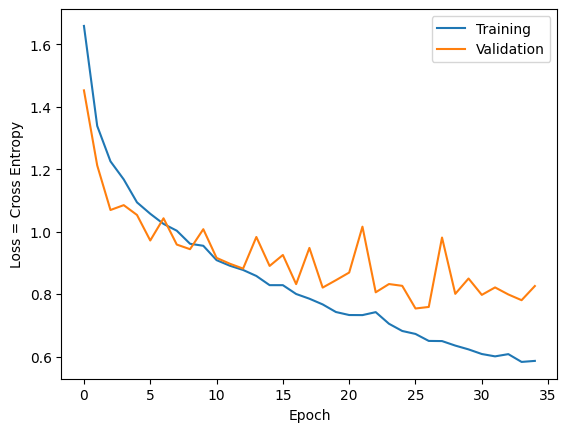

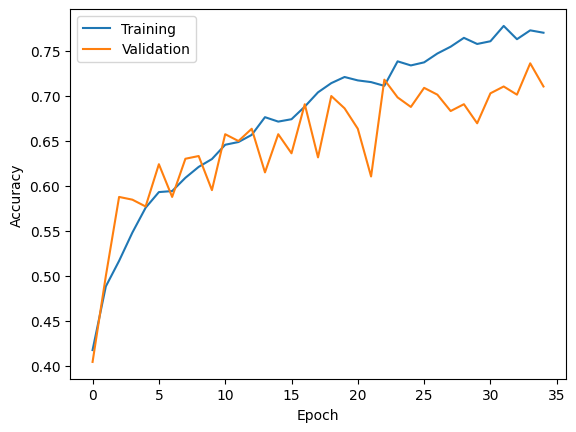

12/12 [==============================] - 1s 65ms/step


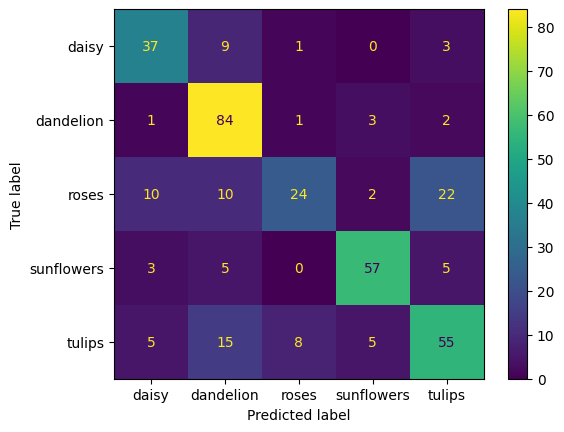

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        50
           1       0.68      0.92      0.79        91
           2       0.71      0.35      0.47        68
           3       0.85      0.81      0.83        70
           4       0.63      0.62      0.63        88

    accuracy                           0.70       367
   macro avg       0.71      0.69      0.68       367
weighted avg       0.70      0.70      0.69       367



In [45]:
loss_accuracy_graph(history)
confusion_matrix_metrics(model)